<a href="https://colab.research.google.com/github/ckbjimmy/2019_tokyo/blob/master/causal_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Causal Inference Workshop

Hands-on Workshops by Satoshi Kimura / Wei-Hung Weng / Ryo Uchimido

March 7, 2019 @ TMDU


---
- [`doWhy` GitHub repo](https://github.com/Microsoft/dowhy)
- [`doWhy` document](https://causalinference.gitlab.io/dowhy/)
- Before running all cells, please go to `FILE > Save a copy in Drive` to save the colab notebook to your own Google Drive.

## Install dependencies


In [0]:
%%capture 
!git clone https://github.com/Microsoft/dowhy.git
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config
!pip install pygraphviz \
 --install-option="--include-path=/usr/include/graphviz" \
 --install-option="--library-path=/usr/lib/graphviz/"
!pip install -r ./dowhy/requirements.txt
!pip install --upgrade pandas
!pip install --upgrade statsmodels
!python ./dowhy/setup.py install
!wget -P ./dowhy/dowhy/causal_estimators/ \
https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/logistic_regression_estimator.py

After running the installation cell, please go to `Runtime > Restart runtime` to reload the updated packages.

## Create a data simulator and define a graph

In [0]:
import numpy as np
import pandas as pd


class DataSimulator(object):
    def __init__(self):
        # Specify the model parameters
        self.sample_size = 5000

        # Specify the prevalence of A (exposure)
        self.p_A = 0.2

        # Parameters for the odds of S (selection)
        self.g0 = np.log(0.10/(1 - 0.10)) # log odds of S for ref group (A = 0 and U = 0)
        self.g1 = np.log(5.0) # log OR for effect of A on log odds of selection (OR = 5.0)
        self.g2 = np.log(5.0) # log OR for effect of U on log odds of selection (OR = 5.0)
        self.g3 = np.log(1.0)  # log OR for interaction between A and U on    (OR = 5.0)

        # Parameters for the odds of Y (outcome)
        # Is S = 0 for reference group correct?
        self.b0 = np.log(0.05/(1 - 0.05)) #log odds of Y for ref group (A = 0, U = 0, and S = 0)
        self.b1 = np.log(1.0) #log OR for effect of A on log odds of Y (OR = 1.0)
        self.b2 = np.log(5.0) #log OR for effect of U on log odds of Y (OR = 5.0)
    
    def prob_C(self, A, U):
        return np.exp(self.g0 + self.g1*A)/(1 + np.exp(self.g0 + self.g1*A))
  
    def prob_S(self, A, U):
        return np.exp(self.g0 + self.g1*A + self.g2*U + self.g3*U*A) / (1 + np.exp(self.g0 + self.g1*A + self.g2*U + self.g3*U*A))

    def prob_Y(self, A, U):
        return np.exp(self.b0 + self.b1*A +  self.b2*U) / (1 + np.exp(self.b0 + self.b1*A + self.b2*U))
      
    def get_graph(self, task):
        if task == 'confounder':
            g = '''
            graph [
            directed 1
            node[id "A" label "A"]
            node[id "Y" label "Y"]
            node[id "C" label "C"]
            edge[source "A" target "Y" weight 1]
            edge[source "C" target "A" weight 1]
            edge[source "C" target "Y" weight 1]
            ]
            '''

            d = '''
            digraph {
            A -> Y;
            C -> A;
            C -> Y;
            }
            '''

        elif task == 'collider':
            g = '''
            graph [
            directed 1
            node[id "A" label "A"]
            node[id "Y" label "Y"]
            node[id "C" label "C"]
            node[id "S" label "S"]
            edge[source "A" target "Y" weight 1]
            edge[source "A" target "S" weight 1]
            edge[source "Y" target "S" weight 1]
            edge[source "C" target "A" weight 1]
            edge[source "C" target "Y" weight 1]
            ]
            '''

            d = '''
            digraph {
            A -> Y;
            A -> S;
            C -> A;
            C -> Y;
            Y -> S;
            U[label="Unobserved Confounders"];
            U -> A;
            U -> Y;
            }
            '''
            
        return g, d

    def get_data(self, task):
        g, d = self.get_graph(task)
        ls_A = stats.binom.rvs(size=self.sample_size, n=1, p=self.p_A)
        ls_U = stats.norm.rvs(size=self.sample_size, loc=0, scale=1)
        p_S = [self.prob_S(ls_A[i], ls_U[i]) for i in range(self.sample_size)]
        p_Y = [self.prob_Y(ls_A[i], ls_U[i]) for i in range(self.sample_size)]
        
        if task == 'confounder':
            return pd.DataFrame({
                'A': ls_A, 
                'C': ls_U, 
                'prob_Y': p_Y, 
                'Y': stats.binom.rvs(size=self.sample_size, n=1, p=p_Y)
            }, columns=['A', 'C', 'prob_Y', 'Y']), g, d
          
        elif task == 'collider':
            return pd.DataFrame({
                'A': ls_A, 
                'C': ls_U, 
                'prob_S': p_S,
                'prob_Y': p_Y, 
                'S': stats.binom.rvs(size=self.sample_size, n=1, p=p_S),
                'Y': stats.binom.rvs(size=self.sample_size, n=1, p=p_Y)
            }, columns=['A', 'C', 'prob_S', 'prob_Y', 'S', 'Y']), g, d

## Load packages and inspect data

In [0]:
import sys
sys.path.append('dowhy')
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import Image, display

from dowhy.do_why import CausalModel
import dowhy.datasets
from dowhy.do_samplers.kernel_density_sampler import KernelDensitySampler
from dowhy.api.causal_data_frame import CausalDataFrame
from statsmodels.api import OLS

In [0]:
# # Using doWhy simulator
# data = dowhy.datasets.linear_dataset(
#     beta=10,
#     num_common_causes=5,
#     num_instruments=2,
#     num_samples=10000,
#     treatment_is_binary=True)

# data = dowhy.datasets.linear_dataset(beta=5,
#         num_common_causes=1,
#         num_instruments = 0,
#         num_samples=1000,
#         treatment_is_binary=True)
# data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

# Simulate our own data

task = 'collider' # change to 'confounder' for another graph

sim = DataSimulator()
data = {}
data['df'], g, d = sim.get_data(task)
data['treatment_name'] = 'A'
data['outcome_name'] = 'Y'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

In [4]:
data

{'df':       A         C    prob_S    prob_Y  S  Y
 0     0 -0.151650  0.080077  0.039600  0  0
 1     0 -0.646302  0.037782  0.018260  0  0
 2     0 -0.505048  0.046973  0.022814  0  0
 3     0  0.256298  0.143720  0.073649  0  0
 4     0  0.622256  0.232233  0.125323  0  0
 5     1 -1.162535  0.078796  0.008038  1  0
 6     0  0.012764  0.101864  0.050985  0  0
 7     0 -0.703452  0.034577  0.016682  0  0
 8     1  0.317688  0.480888  0.080680  1  0
 9     0  1.351336  0.494417  0.316577  0  0
 10    0  0.296037  0.151772  0.078133  0  0
 11    0  0.385314  0.171209  0.089130  0  0
 12    1  1.664860  0.890094  0.434147  1  0
 13    1 -0.487525  0.202228  0.023452  0  0
 14    1  0.439928  0.530026  0.096529  1  0
 15    0  1.858475  0.688663  0.511663  1  1
 16    1  0.932324  0.713559  0.190939  0  1
 17    0  0.390684  0.172439  0.089835  0  0
 18    0  0.922093  0.328898  0.188408  0  0
 19    0 -0.236310  0.070597  0.034731  0  0
 20    0  0.000488  0.100071  0.050037  0  0
 21 

### If we don't consider removing the collider (S)

In [5]:
df = data['df']
model = OLS(df['Y'], df[['C', 'A', 'S']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     353.0
Date:                Thu, 21 Feb 2019   Prob (F-statistic):          6.19e-208
Time:                        01:18:56   Log-Likelihood:                -1063.9
No. Observations:                5000   AIC:                             2134.
Df Residuals:                    4997   BIC:                             2153.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C              0.0904      0.005     19.218      0.000       0.081       0.100
A              0.0675      0.011      6.376      0.000       0.047       0.088
S              0.1291      0.011     11.750      0.000       0.108       0.151
==============================================================================
Omnibus:                     1710.062   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4747.591
Skew:                           1.847   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                         3.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Considering the collider (S) using causal graph

['C']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y


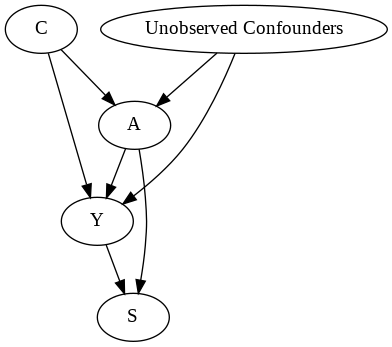

In [6]:
# Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

In [7]:
# Identify causal effect and return target estimands
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'C', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|C))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,C,U) = P(Y|A,C)
### Estimand : 2
Estimand name: iv
No such variable found!



In [8]:
# Estimate the target estimand using a statistical method.
# estimate = model.estimate_effect(identified_estimand,
#                                  method_name="backdoor.propensity_score_matching")

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.logistic_regression") # change to backdoor.linear_regression if the outcome is continuous

print(estimate)
print("Causal Estimate is " + str(estimate.value))

LogisticRegressionEstimator


INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+C


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|C))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,C,U) = P(Y|A,C)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~A+C
## Estimate
Value: 0.13873940131036602

Causal Estimate is 0.13873940131036602


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")

print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+C+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.13873940131036602,)
New effect:(0.13795563626460378,)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The estimated effect increase from 0.0676 to 0.138.

## `test mcmc do sampler.ipynb`

In [0]:
df = data['df']
df['Y'] = df['Y'] + np.random.normal(size=len(df)) # without noise, the variance in Y|X, Z is zero, and mcmc fails.

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'C', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


['C']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler
treatments ['A']
backdoor ['C']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [Y_sd, beta_Y, A_sd, beta_A]
100%|██████████| 2000/2000 [00:26<00:00, 75.24it/s]
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.7-64/lock_dir/lock


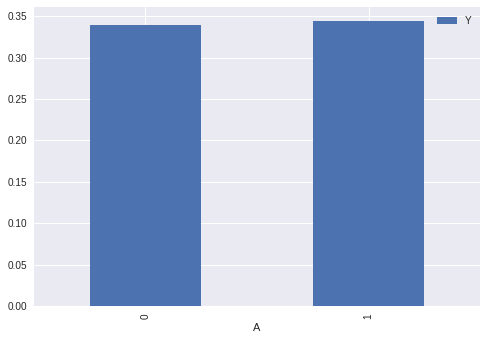

In [13]:
cdf = CausalDataFrame(df)
cdf.causal.do(x={'A': 1}, 
              variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'}, 
              outcome='Y',
              method='mcmc', 
              common_causes=['C'],
              keep_original_treatment=True,
              proceed_when_unidentifiable=True).groupby('A').mean().plot(y='Y', kind='bar')

In [14]:
cdf = CausalDataFrame(df)

cdf_1 = cdf.causal.do(x={'A': 1}, 
              variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'}, 
              outcome='Y',
              method='mcmc', 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = cdf.causal.do(x={'A': 0}, 
              variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'}, 
              outcome='Y',
              method='mcmc', 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True,
              use_previous_sampler=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'C', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


['C', 'U']
yes
{'observed': 'yes'}
no
{'label': 'Unobserved Confounders', 'observed': 'no'}
Model to find the causal effect of treatment A on outcome Y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler
treatments ['A']
backdoor ['C']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [S_sd, beta_S, Y_sd, beta_Y, A_sd, beta_A]
100%|██████████| 2000/2000 [00:41<00:00, 48.56it/s]
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.7-64/lock_dir/lock
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'C', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler


In [15]:
cdf_0

,A,C,prob_S,prob_Y,S,Y
0,0,-0.151650,0.080077,0.039600,1,0
1,0,-0.646302,0.037782,0.018260,1,1
2,0,-0.505048,0.046973,0.022814,0,1
3,0,0.256298,0.143720,0.073649,0,1
4,0,0.622256,0.232233,0.125323,0,1
5,0,-1.162535,0.078796,0.008038,0,0
6,0,0.012764,0.101864,0.050985,0,0
7,0,-0.703452,0.034577,0.016682,0,1
8,0,0.317688,0.480888,0.080680,0,0
9,0,1.351336,0.494417,0.316577,1,0


In [16]:
cdf_1

,A,C,prob_S,prob_Y,S,Y
0,1,-0.151650,0.080077,0.039600,0,0
1,1,-0.646302,0.037782,0.018260,0,0
2,1,-0.505048,0.046973,0.022814,0,0
3,1,0.256298,0.143720,0.073649,1,0
4,1,0.622256,0.232233,0.125323,0,0
5,1,-1.162535,0.078796,0.008038,0,0
6,1,0.012764,0.101864,0.050985,0,0
7,1,-0.703452,0.034577,0.016682,0,0
8,1,0.317688,0.480888,0.080680,1,0
9,1,1.351336,0.494417,0.316577,1,1


In [17]:
(cdf_1['Y'] - cdf_0['Y']).mean()

In [18]:
1.96*(cdf_1['Y'] - cdf_0['Y']).std() / np.sqrt(len(cdf))

In [19]:
model = OLS(df['Y'], df[['C', 'A']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     43.60
Date:                Thu, 21 Feb 2019   Prob (F-statistic):           1.69e-19
Time:                        01:25:12   Log-Likelihood:                -7280.6
No. Observations:                5000   AIC:                         1.457e+04
Df Residuals:                    4998   BIC:                         1.458e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C              0.1249      0.015      8.581      0.000       0.096       0.153
A              0.1182      0.033      3.554      0.000       0.053       0.183
==============================================================================
Omnibus:                        0.966   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.994
Skew:                           0.000   Prob(JB):                        0.608
Kurtosis:                       2.931   Cond. No.                         2.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'C', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


['C']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler
treatments ['A']
backdoor ['C']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [Y_sd, beta_Y, A_sd, beta_A]
100%|██████████| 2000/2000 [00:20<00:00, 99.72it/s] 


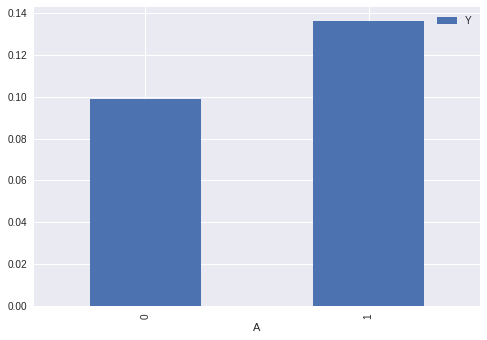

In [20]:
cdf_do = cdf.causal.do(x={'A': 0}, 
              variable_types={'A': 'b', 'C': 'c', 'Y': 'c'}, 
              outcome='Y',
              method='mcmc', 
              common_causes=['C'],
              keep_original_treatment=True,
              proceed_when_unidentifiable=True).groupby('A').mean().plot(y='Y', kind='bar')

In [21]:
cdf_do

## Hands-on exercise: NHEFS data

In [22]:
nhefs = pd.ExcelFile('https://www.dropbox.com/s/nchp1pezska7bim/nhefs.xlsx?dl=1').parse('2017')
nhefs.columns

Index(['seqn', 'qsmk', 'death', 'yrdth', 'modth', 'dadth', 'sbp', 'dbp', 'sex',
       'age', 'race', 'income', 'marital', 'school', 'education', 'ht', 'wt71',
       'wt82', 'wt82_71', 'birthplace', 'smokeintensity', 'smkintensity82_71',
       'smokeyrs', 'asthma', 'bronch', 'tb', 'hf', 'hbp', 'pepticulcer',
       'colitis', 'hepatitis', 'chroniccough', 'hayfever', 'diabetes', 'polio',
       'tumor', 'nervousbreak', 'alcoholpy', 'alcoholfreq', 'alcoholtype',
       'alcoholhowmuch', 'pica', 'headache', 'otherpain', 'weakheart',
       'allergies', 'nerves', 'lackpep', 'hbpmed', 'boweltrouble', 'wtloss',
       'infection', 'active', 'exercise', 'birthcontrol', 'pregnancies',
       'cholesterol', 'hightax82', 'price71', 'price82', 'tax71', 'tax82',
       'price71_82', 'tax71_82'],
      dtype='object')

['age', 'diabetes']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment qsmk on outcome wt82_71


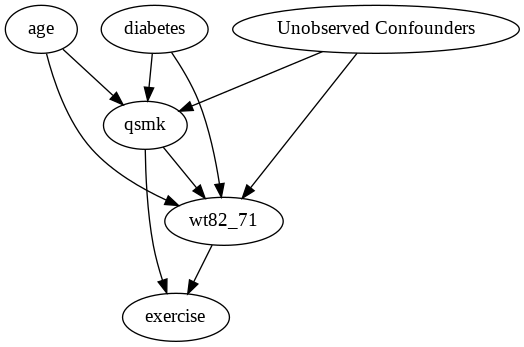

In [23]:
g = '''
graph [
directed 1
node[id "qsmk" label "qsmk"]
node[id "wt82_71" label "wt82_71"]
node[id "age" label "age"]
node[id "diabetes" label "diabetes"]
node[id "exercise" label "exercise"]
edge[source "qsmk" target "wt82_71" weight 1]
edge[source "qsmk" target "exercise" weight 1]
edge[source "wt82_71" target "exercise" weight 1]
edge[source "age" target "qsmk" weight 1]
edge[source "age" target "wt82_71" weight 1]
edge[source "diabetes" target "qsmk" weight 1]
edge[source "diabetes" target "wt82_71" weight 1]
]
'''

d = '''
digraph {
qsmk -> wt82_71;
qsmk -> exercise;
age -> qsmk;
age -> wt82_71;
diabetes -> qsmk;
diabetes -> wt82_71;
wt82_71 -> exercise;
U[label="Unobserved Confounders"];
U -> qsmk;
U -> wt82_71;
}
'''

selected = ['age', 'diabetes', 'qsmk', 'wt82_71', 'exercise']

data = {}
data['df'] = nhefs[selected]
data['treatment_name'] = 'qsmk'
data['outcome_name'] = 'wt82_71'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

In [24]:
identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True)

print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'age', 'diabetes'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: wt82_71~qsmk+age+diabetes


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|age,diabetes))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,age,diabetes,U) = P(wt82_71|qsmk,age,diabetes)
### Estimand : 2
Estimand name: iv
No such variable found!

LinearRegressionEstimator


ValueError: ignored

In [25]:
nhefs[selected].isnull().values.any()

True

['age', 'diabetes']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment qsmk on outcome wt82_71


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

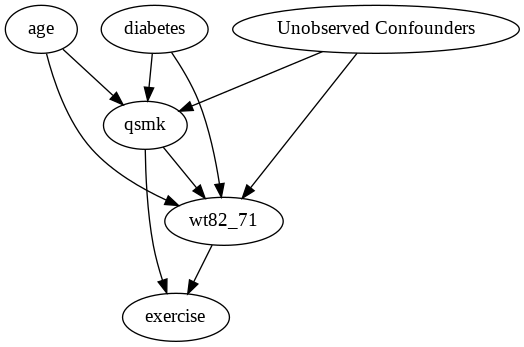

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'age', 'diabetes'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: wt82_71~qsmk+age+diabetes


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|age,diabetes))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,age,diabetes,U) = P(wt82_71|qsmk,age,diabetes)
### Estimand : 2
Estimand name: iv
No such variable found!

LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|age,diabetes))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,age,diabetes,U) = P(wt82_71|qsmk,age,diabetes)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: wt82_71~qsmk+age+diabetes
## Estimate
Value: 2.9910851658426028

## Statistical Significance
p-value: <0.001

Caus

In [26]:
from sklearn.preprocessing import Imputer

nhefs_imputed = nhefs
for i in selected:
  imputer = Imputer(missing_values="NaN", strategy="mean")
  nhefs_imputed[i] = imputer.fit_transform(nhefs[[i]]) 

data = {}
data['df'] = nhefs_imputed
data['treatment_name'] = 'qsmk'
data['outcome_name'] = 'wt82_71'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True)

print(estimate)
print("Causal Estimate is " + str(estimate.value))